## Model:QA Calls For Evaluation
Logging every call to the chain for later review/analysis

In [2]:
%pip install langchain langsmith --quiet
%pip cache purge

Files removed: 132


In [3]:
%pip install optimum --quiet

In [21]:
!pip install langchain_community --quiet
!pip install langchain_openai --quiet
!pip install huggingface_hub --quiet
!pip install openai==0.28 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.3.27 requires openai<2.0.0,>=1.86.0, but you have openai 0.28.0 which is incompatible.


In [2]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from langchain.vectorstores import FAISS
#from langchain_openai import OpenAI
from langchain.chains import RetrievalQA
from langchain import HuggingFaceHub
from langchain_community.embeddings import HuggingFaceEmbeddings
from transformers import pipeline
from dotenv import load_dotenv
import os
import openai

 ## Define Pipelines

In [3]:
from transformers import pipeline

hf_pipes = {
    "distilgpt2": pipeline("text-generation", model="distilgpt2", max_new_tokens=64),
    "flan-t5-base": pipeline("text2text-generation", model="google/flan-t5-base", max_new_tokens=64),
    "flan-t5-large": pipeline("text2text-generation", model="google/flan-t5-large", max_new_tokens=64),
}

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [4]:
import requests
from google.colab import userdata
TOGETHER_API_KEY = userdata.get('TOGETHER_TOKEN')

def together_mistral_call(prompt, max_tokens=128, temp=0.0):
    url = "https://api.together.xyz/v1/completions"
    headers = {"Authorization": f"Bearer {TOGETHER_API_KEY}"}
    payload = {
        "model": "mistralai/Mistral-7B-Instruct-v0.2",
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": temp,
        "stop": None
    }
    response = requests.post(url, headers=headers, json=payload)
    try:
        result = response.json()
        if "choices" in result and result["choices"]:
            return result["choices"][0]["text"].strip()
        elif "error" in result:
            return f"API error: {result['error']}"
        else:
            return str(result)
    except Exception as e:
        return f"Non-JSON response: {response.text[:200]}"

In [5]:
import openai

def openai_gpt35_call(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=64
    )
    return response.choices[0].message.content.strip()

In [6]:
test_set = [
    {"question": "What is ServiceNow?", "gold_answer": "ServiceNow is a cloud platform for digital workflows."},
    {"question": "Explain ITSM.", "gold_answer": "ITSM stands for IT Service Management."},
]

## Evaluation Loop

In [7]:
from tqdm import tqdm

results = []

for example in tqdm(test_set):
    q = example["question"]
    gold = example["gold_answer"]
    row = {"question": q, "gold_answer": gold}
    for name, pipe in hf_pipes.items():
        if 'text2text' in pipe.task:
            try:
                out = pipe(q)[0]['generated_text']
            except Exception as e:
                out = str(e)
        else:
            try:
                out = pipe(q)[0]['generated_text']
            except Exception as e:
                out = str(e)
        row[name] = out
    try:
        row["mistral-7b"] = together_mistral_call(q)
    except Exception as e:
        row["mistral-7b"] = f"Together.ai error: {e}"
    try:
        row["gpt-3.5-turbo"] = openai_gpt35_call(q)
    except Exception as e:
        row["gpt-3.5-turbo"] = f"OpenAI error: {e}"

    results.append(row)

100%|██████████| 2/2 [00:07<00:00,  3.62s/it]


In [8]:
for r in results[:5]:
    print("Mistral output:", repr(r.get("mistral-7b", "")))

Mistral output: 'ServiceNow is a cloud-based IT service management (ITSM) platform that helps businesses manage and automate IT services and processes. It provides a single system of record for IT operations, enabling organizations to streamline their IT service delivery, improve service quality, and reduce costs.\n\nServiceNow offers a wide range of IT service management capabilities, including incident management, problem management, change management, service request management, and service level management. It also provides integration with other IT tools and systems, such as IT asset management, IT financial management, and IT operations management.\n\nServiceNow is used by organizations of all sizes'
Mistral output: 'Q: What is ITSM, and why is it important for businesses?\n\nA: ITSM, or IT Service Management, is a set of practices, processes, and tools designed to align IT services with the needs of businesses. It helps organizations manage and deliver IT services effectively an

## Calculate Metrics

In [9]:
from sklearn.metrics import f1_score

def token_f1(a, b):
    a, b = set(str(a).lower().split()), set(str(b).lower().split())
    if not a or not b:
        return 0.0
    common = a & b
    precision = len(common) / len(a)
    recall = len(common) / len(b)
    return 2 * precision * recall / (precision + recall + 1e-8)
model_names = list(hf_pipes.keys()) + ["mistral-7b", "gpt-3.5-turbo"]

for r in results:
    for model in model_names:
        r[f'{model}_f1'] = token_f1(r.get(model, ""), r['gold_answer'])


## Compare Results

In [10]:
from sklearn.metrics import f1_score

def token_f1(a, b):
    a, b = set(a.lower().split()), set(b.lower().split())
    if not a or not b: return 0.0
    common = a & b
    precision = len(common)/len(a)
    recall = len(common)/len(b)
    return 2*precision*recall/(precision+recall+1e-8)

import pandas as pd
df = pd.DataFrame(results)

for model in ["distilgpt2", "flan-t5-base", "flan-t5-large", "mistral-7b", "gpt-3.5-turbo"]:
    df[f"{model}_f1"] = df.apply(lambda r: token_f1(str(r[model]), str(r["gold_answer"])), axis=1)

print(df[[f"{model}_f1" for model in ["distilgpt2", "flan-t5-base", "flan-t5-large", "mistral-7b", "gpt-3.5-turbo"]]].mean())


distilgpt2_f1       0.090909
flan-t5-base_f1     0.363971
flan-t5-large_f1    0.319298
mistral-7b_f1       0.132165
gpt-3.5-turbo_f1    0.103778
dtype: float64


In [11]:
for i, row in enumerate(results):
    print(f"Q: {row['question']}")
    print(f"Mistral-7B: {row.get('mistral-7b', '')}")
    print(f"Flan-T5-Base: {row.get('flan-t5-base', '')}")
    print(f"GPT-3.5-turbo: {row.get('gpt-3.5-turbo', '')}")
    print("---")
    if i > 3: break

Q: What is ServiceNow?
Mistral-7B: ServiceNow is a cloud-based IT service management (ITSM) platform that helps businesses manage and automate IT services and processes. It provides a single system of record for IT operations, enabling organizations to streamline their IT service delivery, improve service quality, and reduce costs.

ServiceNow offers a wide range of IT service management capabilities, including incident management, problem management, change management, service request management, and service level management. It also provides integration with other IT tools and systems, such as IT asset management, IT financial management, and IT operations management.

ServiceNow is used by organizations of all sizes
Flan-T5-Base: ServiceNow is a software company based in Seattle, Washington.
GPT-3.5-turbo: OpenAI error: No API key provided. You can set your API key in code using 'openai.api_key = <API-KEY>', or you can set the environment variable OPENAI_API_KEY=<API-KEY>). If your 

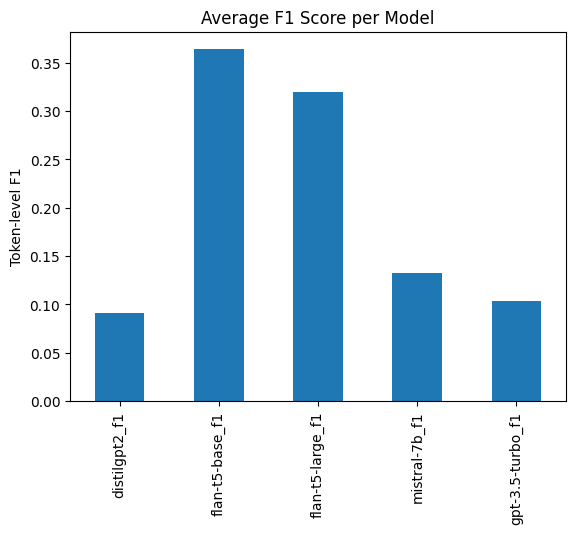

In [12]:
import matplotlib.pyplot as plt

means = df[[f"{model}_f1" for model in ["distilgpt2", "flan-t5-base", "flan-t5-large", "mistral-7b", "gpt-3.5-turbo"]]].mean()
means.plot(kind="bar", title="Average F1 Score per Model")
plt.ylabel("Token-level F1")
plt.show()

In [13]:
import pandas as pd
df = pd.DataFrame(results)
df.to_csv("all_model_eval_results.csv", index=False)
df.head()

,question,gold_answer,distilgpt2,flan-t5-base,flan-t5-large,mistral-7b,gpt-3.5-turbo,distilgpt2_f1,flan-t5-base_f1,flan-t5-large_f1,mistral-7b_f1,gpt-3.5-turbo_f1
0,What is ServiceNow?,ServiceNow is a cloud platform for digital wor...,What is ServiceNow?\n\n\n\n\n\n\n\n\n\n\n\n\n\...,ServiceNow is a software company based in Seat...,serviceNow is a cloud-based service management...,ServiceNow is a cloud-based IT service managem...,OpenAI error: No API key provided. You can set...,0.181818,0.352941,0.533333,0.144928,0.122449
1,Explain ITSM.,ITSM stands for IT Service Management.,Explain ITSM.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...,ITSM is an acronym for Information Technology ...,"ITSM is the process of developing, deploying, ...","Q: What is ITSM, and why is it important for b...",OpenAI error: No API key provided. You can set...,0.000000,0.375000,0.105263,0.119403,0.085106


## LLM Loop Evaluation

In [14]:
def build_judge_prompt(question, gold_answer, model_answer):
    return (
        f"You are a helpful expert assistant evaluating an answer to a question.\n"
        f"Question: {question}\n"
        f"Reference answer: {gold_answer}\n"
        f"Model answer: {model_answer}\n"
        "Is the model answer factually correct and complete with respect to the reference answer? "
        "Reply only with 'Yes' or 'No' and a very short reason."
    )


In [15]:
import openai

def llm_judge_eval(question, gold_answer, model_answer):
    prompt = build_judge_prompt(question, gold_answer, model_answer)
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=32,
        temperature=0.0,
    )
    reply = response.choices[0].message.content.strip()
    # Parse "Yes" or "No" from reply (optional: also save reason)
    if reply.lower().startswith("yes"):
        return 1
    elif reply.lower().startswith("no"):
        return 0
    else:
        return None  # or handle as needed

In [19]:
openai.api_key= userdata.get('OPENAI_API_KEY')
model_names = list(hf_pipes.keys()) + ["mistral-7b", "gpt-3.5-turbo"]
for r in results:
    for model in model_names:
        r[f"{model}_llm_judge"] = llm_judge_eval(r["question"], r["gold_answer"], r.get(model, ""))


In [20]:
# If 1 = Pass, 0 = Fail
judge_scores = {m: sum(r[f"{m}_llm_judge"] for r in results if r.get(f"{m}_llm_judge") is not None)/len([r for r in results if r.get(f"{m}_llm_judge") is not None]) for m in model_names}
print(judge_scores)

{'distilgpt2': 1.0, 'flan-t5-base': 0.0, 'flan-t5-large': 1.0, 'mistral-7b': 1.0, 'gpt-3.5-turbo': 0.0}


## Observations:
* F1 Score Sensitivity:Models that generate accurate but paraphrased or more elaborate responses will often receive a low F1 score, even when their answers are correct and informative.
* Paraphrasing and Robustness:During manual review, the Mistral-7B model consistently provided robust, well-structured, and contextually appropriate answers. However, because it frequently rephrased or expanded upon the gold answers, its F1 scores were lower than those of models that more closely mimicked the reference text.
* LLM Loop Evaluation: During this Evaluation, Distilgpt2, flat-t5-latge and mistral-7b are passed the evaluation as they are having better response then flat-t5-base and gpt-3.5-turbo

In this evaluation, although Flan-T5 models achieved higher F1 scores, manual inspection revealed that Mistral-7B’s answers were often more robust and contextually nuanced. This highlights the importance of not relying solely on automated scoring metrics for open-ended question answering tasks.